# A${}^*$アルゴリズムで迷路を解く
対応する動画：[A*で迷路を解く【研究で使うPython #76】](https://youtu.be/m9dOCHAkX6g)

動画のプレイリスト：[研究で使うPython](https://youtube.com/playlist?list=PLw5AEs-T7pLHxLaNvGD9tnhrDxAgH-QIw)

In [1]:
## ライブラリの準備
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import matplotlib.animation as animation
from IPython import display

## 壁を表す定数
WALL = 100000

## 迷路クラス
* フィールド
    * `width`, `height`: 迷路の横幅と高さ（四方を囲む壁も含む）
    * `data`: 迷路のデータ（2次元リスト形式; 壁がWALLの値，それ以外が0）
    * `start`, `goal`: スタート地点とゴール地点の座標（(x,y)のタプル形式）
* メソッド
    * `__init__`: `'x'`と`' '`で表現されたテキスト形式の迷路データを受け取って初期化する
    * `plot_maze`: 迷路をプロットする
    * `plot_path`: 経路を渡して迷路とともにプロットする
    * `plot_field`: 経路探索に使った値を重ねてプロットする（アニメーションで使う）

In [2]:
class Maze:
    
    def __init__(self, texts):
        """
        初期化用メソッド
        
        ・texts: 迷路の初期化用テキスト．次のような形式を受け取れる:
            maze_texts = [
                'xxxxxxxxxxx',
                'x       xGx',
                'x xxxxx x x',
                'x     x   x',
                'x xxx xxxxx',
                'x x x     x',
                'x x xxxxx x',
                'x   x     x',
                'x xxx xxx x',
                'xS    x   x',
                'xxxxxxxxxxx',
            ]
        ただし，xが壁で空白が進めるマス，SとGがそれぞれスタート地点とゴール地点を表す
        """
        
        self.height, self.width = len(texts), len(texts[0])  ## 横幅と高さを取得
        self.data = [[0 for j in range(self.width)] 
                     for i in range(self.height)]    ## 迷路のデータを初期化

        for y, text in enumerate(texts):
            for x, s in enumerate(text):
                if s == 'x':
                    self.data[y][x] = WALL  ## 壁だったらWALLの値で更新
                elif s == 'S':
                    self.start = (x, y)     ## スタート地点を記録
                elif s == 'G':
                    self.goal = (x, y)      ## ゴール地点を記録

        


    def plot_maze(self, ax=None):
        """
        壁を黒，そうでない場所を白，スタート地点を青丸，ゴール地点を赤丸の形式でプロットする
        
        ・ax: プロットするaxisを指定する．デフォルトはNone
        """
        
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6,6))
        
        ax.axis('off')

        im = ax.imshow(self.data, cmap='Greys', origin='lower')
        
        sc_st = ax.scatter([self.start[0]], [self.start[1]], c='b', s=300)
        tx_st = ax.text(self.start[0], self.start[1], 'S', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        sc_go = ax.scatter([self.goal[0]],  [self.goal[1]],  c='r', s=300)
        tx_go = ax.text(self.goal[0],  self.goal[1],  'G', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        return [im] + [sc_st] + [tx_st] + [sc_go] + [tx_go]
    
    
    
    def plot_path(self, path, ax=None):
        """
        迷路と経路をプロットする
        
        ・path: 表示したい経路．座標のリスト形式を受け付ける（座標は(x,y)のタプル形式を想定）
        ・ax: プロットするaxisを指定する．デフォルトはNone
        """
        
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6,6))
        
        ax.axis('off')

        im = ax.imshow(self.data, cmap='Greys', origin='lower')
        
        arrows = []
        for b, g in zip(path[:-1], path[1:]):
            d = (g[0]-b[0], g[1]-b[1])
            ar = ax.arrow(*b, *d, length_includes_head=True, head_width=0.2, zorder=1)
            arrows.append(ar)
        
        sc_st = ax.scatter([self.start[0]], [self.start[1]], c='b', s=300)
        tx_st = ax.text(self.start[0], self.start[1], 'S', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        sc_go = ax.scatter([self.goal[0]],  [self.goal[1]],  c='r', s=300)
        tx_go = ax.text(self.goal[0],  self.goal[1],  'G', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        return [im] + arrows + [sc_st] + [tx_st] + [sc_go] + [tx_go]
    

    
    def plot_field(self, field, func, ax=None, cm='Greens'):
        """
        経路探索に使用したフィールドの値を迷路に重ねてプロットする
        
        ・field: プロットしたいフィールド．迷路と同サイズを想定
        ・func: 探索に使用したヒューリスティック関数
        ・ax: プロットするaxisを指定する．デフォルトはNone
        ・cm: フィールドの値を表示する際のカラーマップの種類．デフォルトはGreen
        """
        
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6,6))
        
        ax.axis('off')
        
        vmx = self.width*self.height - np.sum(np.array(self.data))/WALL \
                + func((0,0), (self.width-2, self.height-2))
        fld = ax.imshow(field, cmap=cm, origin='lower', 
                  vmin=0.,  vmax=vmx)
        
        wall_arr = np.array([[([0,0,0,1] if self.data[y][x] == WALL else [0,0,0,0]) 
                              for x in range(self.width)] 
                             for y in range(self.height)], dtype=float)
        wall = ax.imshow(wall_arr, cmap='Greys', origin='lower')
        
        sc_st = ax.scatter([self.start[0]], [self.start[1]], c='b', s=300)
        tx_st = ax.text(self.start[0], self.start[1], 'S', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        sc_go = ax.scatter([self.goal[0]],  [self.goal[1]],  c='r', s=300)
        tx_go = ax.text(self.goal[0],  self.goal[1],  'G', ha='center', va='center', 
                        fontsize=15, c='w', weight='bold')
        
        return [fld] + [wall] + [sc_st] + [tx_st] + [sc_go] + [tx_go]

## 迷路オブジェクトの作成

In [3]:
## 迷路を適当に指定
maze_data = [
    'xxxxxxxxxxx',
    'x       xGx',
    'x xxxxx x x',
    'x     x   x',
    'x xxx xxxxx',
    'x x x     x',
    'x x xxxxx x',
    'x   x     x',
    'x xxx xxx x',
    'xS    x   x',
    'xxxxxxxxxxx',
]

maze_data = maze_data[::-1] ## 迷路の2次元リストを逆順に

## 迷路の可視化

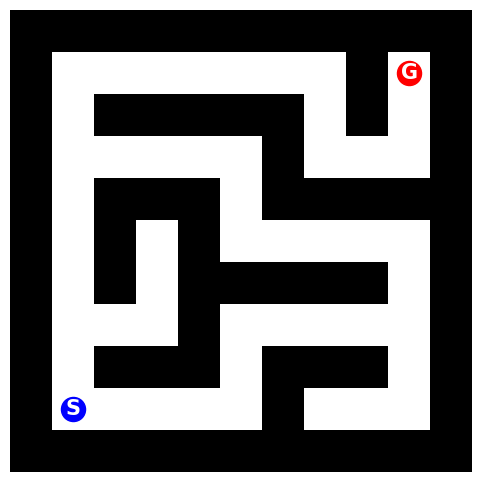

In [4]:
m = Maze(maze_data)
m.plot_maze();

## A${}^*$アルゴリズムの実行関数

In [5]:
def execute_Astar(maze, func_H, animate=False):
    """
    A*アルゴリズムを実行して最短経路を示す

    * maze: 経路探索する迷路
    * func_H: ヒューリスティック関数 H
    * animate: アニメーション形式で表示するか（デフォルトはFalse，Trueだと最短経路のみ表示）
    """
    
    if animate:
        ## アニメーション描画用の領域を作成
        fig, ax = plt.subplots(1, 1, figsize=(6,6))

        ims = []  ## 調査するごとのフィールドの図をメモしていくリスト
    
    
    
    ## 調査し終えたどうか（および壁かどうか）を表すフィールド
    ## （未調査なら0，調査済みあるいは壁なら1以上）
    close_field = copy.deepcopy(maze.data)
    
    ## スタートからの最短距離(関数G)をメモしていくフィールド
    G_field = [[WALL for x in range(maze.width)] for y in range(maze.height)]
    
    ## A*アルゴリズムで使用する関数Fをメモしていくフィールド
    F_field = [[WALL for x in range(maze.width)] for y in range(maze.height)]
    
    ## 調査予定の座標セット
    open_set = {maze.start}
    
    ## スタート地点のGをゼロに，Fの値をG+Hに設定する
    G_field[maze.start[1]][maze.start[0]] = 0
    F_field[maze.start[1]][maze.start[0]] = func_H(maze.start, maze.goal)
    

    focal = None    ## 調査中の座標を表す変数
    trial = 0       ## 試行回数のカウンタ
    
    ## 調査予定の座標がなくなるまで繰り返す
    while len(open_set) > 0:
        
        if animate:
            ## フィールドの値をプロットしてimsに追加
            ims.append(maze.plot_field(F_field, func_H, ax=ax))
        
        
        trial += 1      ## 試行回数を増加
        
        ## 調査予定の座標セットから，最もFの値が小さいものを見つけてfocalにセットする
        F_min = WALL
        for x, y in open_set:
            if F_field[y][x] < F_min:
                focal = (x, y)
                F_min = F_field[y][x]
        
        ## focalにセットした座標は調査予定群から取り除き，調査済みとする
        open_set.remove(focal)
        close_field[focal[1]][focal[0]] = 1
        
        
        ## もしfocalがゴール地点であれば，探索は終了する
        if focal[0] == maze.goal[0] and focal[1] == maze.goal[1]:
            break
        
        
        ## focalから上下左右の操作で移動可能な座標を順番に見ていく
        for x, y in [[1,0], [0,1], [-1,0], [0,-1]]:
            
            ## 移動後の座標をneighborと呼ぶ
            neighbor = (focal[0]+x, focal[1]+y)
            
            ## もしneighborが調査済みあるいは壁なら，移動不可能なので次へ
            if close_field[neighbor[1]][neighbor[0]] > 0:
                continue
            
            ## neighborにおける最短距離Gをfocalの最短距離+1で更新
            G = G_field[focal[1]][focal[0]] + 1
            
            ## neighborにおけるHの値を計算
            H = func_H(neighbor, maze.goal)
            
            ## もし今計算したF=G+Hの値が，事前にメモされていたFの値より小さければ更新
            if F_field[neighbor[1]][neighbor[0]] > G + H:
                G_field[neighbor[1]][neighbor[0]] = G
                F_field[neighbor[1]][neighbor[0]] = G + H
            
            ## 調査予定セットにneighborを加える（セットなので既に存在していたら変化なし）
            open_set.add(neighbor)
    
    ## ゴール地点を見つけられないまま繰り返しが終了した場合
    else:
        print("ゴールまでの経路が見つかりませんでした")
        return
    
    
    
    ## スタート地点からゴール地点までの最短経路をゴール地点から遡って求める
    path = [maze.goal]
    
    ## 上記の繰り返しを抜けた段階ではfocalがゴール地点を指している．そこから
    ## スタート地点に至るまで一歩ずつ戻っていく
    while not(focal[0] == maze.start[0] and focal[1] == maze.start[1]):
        
        ## 移動可能地点を全て探索
        for x, y in [[1,0], [0,1], [-1,0], [0,-1]]:
            neighbor = (focal[0]+x, focal[1]+y)  ## 移動後座標をneighborと呼ぶ
            
            ## もしneighborのGの値がfocalのGの値より1だけ小さかったら，
            ## neighborは最短経路に含まれるのでfocalを更新．forループを抜ける
            if G_field[focal[1]][focal[0]] - G_field[neighbor[1]][neighbor[0]] == 1:
                path.append(neighbor)
                focal = neighbor
                break
    
    print(trial)         ## 調査した回数を表示
    print(path[::-1])    ## 経路を表示（ゴール→スタートの順になっているので逆順にする必要あり）
    
    
    
    ## アニメーションを生成する場合
    if animate:
        ## imsを使ってアニメーションを作成
        ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000)

        ## アニメーションをHTML形式にして表示
        html = display.HTML(ani.to_jshtml())
        display.display(html)
        plt.close()
    
    
    ## いずれにせよ最短経路はプロットする
    maze.plot_path(path[::-1])   ## 経路をプロット

## A${}^*$アルゴリズムを実行して最短経路を表示

41
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9)]


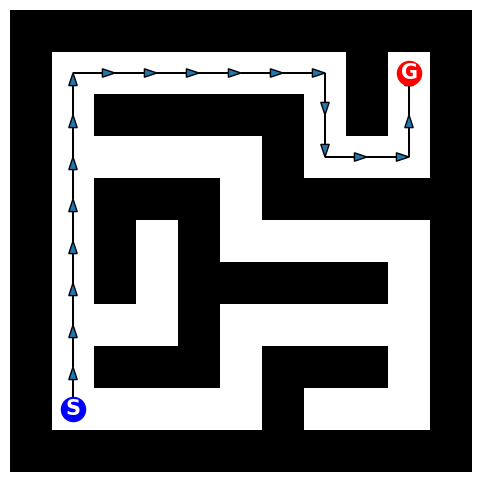

In [6]:
## 関数Hはゴールとの距離の二乗とする
func = lambda a,b: (a[0]-b[0])**2+(a[1]-b[1])**2

execute_Astar(m, func)

## A${}^*$アルゴリズムを実行していくときのFの値をプロット

* 緑が濃いほどFの値は小さい
* 初期段階ではFの値を非常に大きい値にセットしてあるので全部緑になる

41
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9)]


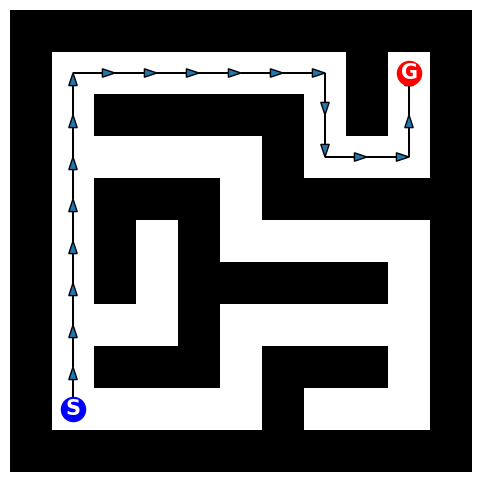

In [7]:
execute_Astar(m, func, animate=True)

## A${}^*$ではなくダイクストラ法を実行していくときのFの値をプロット

* H関数の値を常にゼロとするとダイクストラ法になる

50
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (7, 8), (7, 7), (8, 7), (9, 7), (9, 8), (9, 9)]


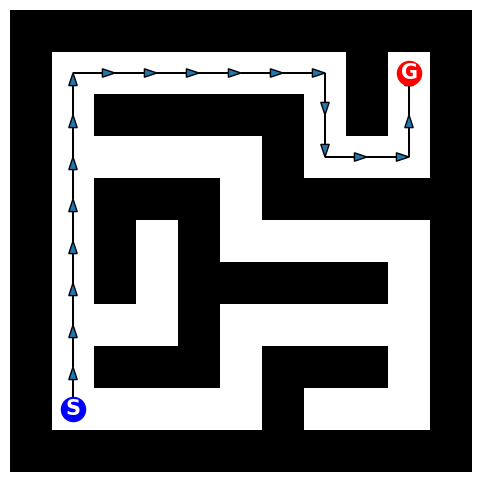

In [8]:
#func = lambda a,b: (a[0]-b[0])**2+(a[1]-b[1])**2
func = lambda a,b: 0.
execute_Astar(m, func, animate=True)

## NetworkXの関数で解く

In [9]:
"""
迷路クラスをグラフに変換する関数
"""

def conv_maze_to_graph(maze):
    m = maze
    Graph = nx.grid_2d_graph(m.width//2, m.height//2, periodic=False)
    
    for y in range(1, m.height-1, 2):
        for x in range(2, m.width-1, 2):
            if m.data[y][x] > 0:
                l = ((x-2)//2, (y-1)//2)
                r = ((x-0)//2, (y-1)//2)
                Graph.remove_edge(l, r)
                
        
    for y in range(2, m.height-1, 2):
        for x in range(1, m.width-1, 2):
            if m.data[y][x] > 0:
                b = ((x-1)//2, (y-2)//2)
                t = ((x-1)//2, (y-0)//2)
                Graph.remove_edge(b, t)
    
    ## 移動コストを示す属性をリンクに付与する必要がある．今回は一律に1とする．
    nx.set_edge_attributes(Graph, {e: 1 for e in Graph.edges()}, "cost")
    return Graph

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (3, 3), (4, 3), (4, 4)]


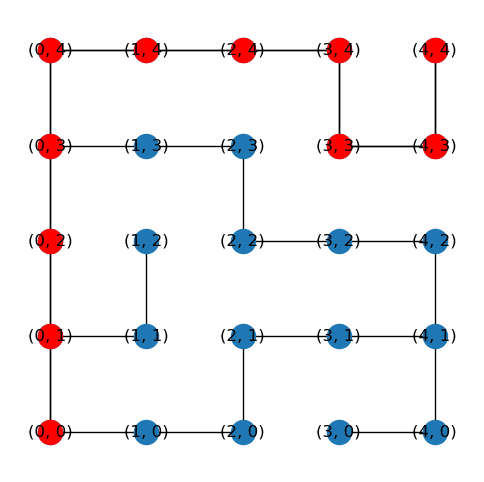

In [10]:
## 迷路をグラフ形式に変換
MG = conv_maze_to_graph(m)

## プロット用の領域を確保
fig, ax = plt.subplots(1, 1, figsize=(6,6))
## ノードの座標を指定
pos = {(x,y):(x,y) for x,y in MG.nodes()}

## 迷路グラフを表示
nx.draw(MG, pos, ax=ax)
nx.draw_networkx_labels(MG, pos, ax=ax);

## 関数Hを定義
func = lambda a,b: (a[0]-b[0])**2+(a[1]-b[0])**2

## NetworkXの関数に渡すと経路が得られる
## （引数：グラフ，スタート地点，ゴール地点，関数H，移動コストのラベル）
path = nx.astar_path(MG, (0,0), (4,4), heuristic=func, weight='cost')
print(path)

## 経路を重ねてプロットする
SP = nx.Graph()
SP.add_nodes_from(path)
SP.add_edges_from([(n1, n2) for n1, n2 in zip(path[:-1], path[1:])])
pos = {(x,y):(x,y) for x,y in SP.nodes()}
nx.draw(SP, pos, node_color='r', ax=ax)